# 如何理解一个机器学习算法：以XGboost和Quora实战为例 by 小序

## 有监督机器学习的一般规律

机器学习是对我们已有的训练数据进行建模的一个过程。

既然是建模，那么求出模型中的参数$\theta $是关键。

为了求出最好的$\theta $，我们需要构建一个目标函数

$Obj(\Theta) = L(\theta) + \Omega(\Theta)$

目标函数由两个部分组成：损失函数与正则项。

损失函数用来测量我们的模型对训练数据的预测能力有多强，常见的损失函数有

$L(\theta) = \sum_i (y_i-\hat{y}_i)^2$

正则项用来控制模型的复杂度，以防止过拟合出现。

以上是理解有监督机器学习的一个框架，任何有监督机器学习的算法都是在这个框架上进行调整的。

理想的情况，我们希望我们的损失函数最优使我们的模型预测力越强越好，我们的正则项使我们的模型越简单越好。

有了上面这个框架，我们就可以把XGboost这个算法当作这个框架的一个实例来理解。

## XGboost的核心思想:用CART回归树来预测

我们现在的目标是写出XGboost的目标函数(objective function)。

在这之前，我们需要先理解一下XGboost的思想。

简单而言，它是通过许多棵随机树(Classification and Regression Tree)对数据进行回归建模。

什么是随机树？

它是长成这样的东西。

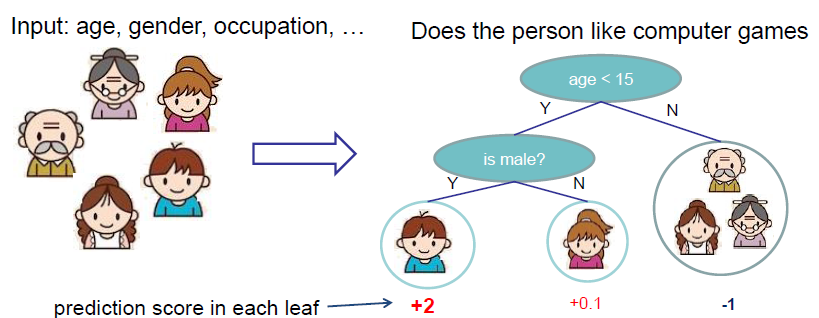

在上面这个例子中，我们知道一些简单的人口统计学信息，比如年龄、职业等，然后我们要预测每个被试是否喜欢玩电脑游戏。

它的特征就是分支以及每片叶子都有一个分数。这个叶子下的人如果越有可能玩电脑游戏则分数越高。

## 对图进行目标函数建模

好了，下面我们就可以对这个树图进行建模。

$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$

我们需要求出这个上面这个函数f(k)

而f(k)是由三个参数决定的：

+ 树的棵树
+ 每颗树下面的分数
+ 树的结构或者分叉的规则

如果我们画一个f(k)的图像可能是像下面这样的：

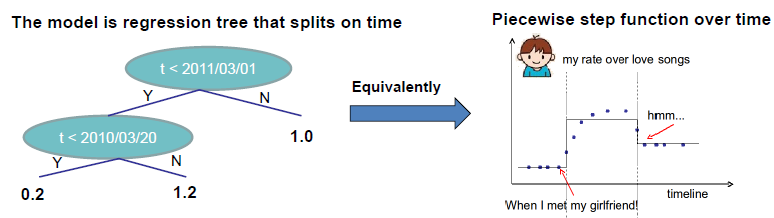

我们需要在函数的预测性与复杂度之间做一个权衡：

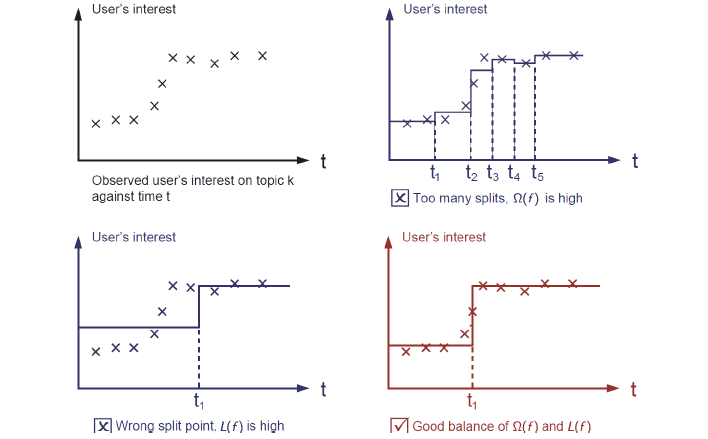

## 写出我们的目标函数

$\text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$

下面就是进入正题：我们要调整这个目标函数的结构来求出我们的参数。

### 先来击破损失函数

我们先来看我们的损失函数。

在这里我们的损失函数采用最常用的Expected Square Loss。经典的线性回归用的也是这个函数。

我们的目标就是使我们的Expected Square Loss最小。

$L(\theta) = \sum_i (y_i-\hat{y}_i)^2$最小。

和线性回归不同，在这里我们没有办法用经典的随机梯度下降法求这个损失函数的最小值，我们只能换一个方法。这个方法我们称为Additive Training。

我们通过，第0个样例的预测值和f(k)来推出第1个样例的预测值。

我们再通过第1个样例的预测值和f(k)来退出第2个样例的预测值。

我们通过第t-1个样例的预测值和f(k)来退出第t个样例的预测值。

有点像数学归纳法是不是！有点像递推算法是不是！

$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}$

于是乎，我们在第t轮的目标函数就变成了

$\begin{split}\text{obj}^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + constant
\end{split}$

然后用MSE当成我们的损失函数来进一步推算上面的公式就变成了

$\begin{split}\text{obj}^{(t)} & = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \Omega(f_t) + constant
\end{split}$

下面我们引入亲爱的泰勒展开进一步计算

$\text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + constant$

其中

\begin{split}g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})
\end{split}

最后的最后，我们的目标函数化简成

$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$

这样就变成了一个高中数学中的一元二次抛物线求极值问题了。

### 再来击破正则项

首先我们对树这个图进行进一步的函数定义：

$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\}$

其中W是一个向量，用来代表每片叶子下的分数。

q是一个函数，用来代表哪个样例分配到哪个叶子下。

T是叶子的数量。

于是我们的正则项如下：

$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$

### 开始求极值

我们令

$G_j = \sum_{i\in I_j} g_i$

$H_j = \sum_{i\in I_j} h_i$

我们的目标函数可以进一步简化成

$\text{obj}^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T$

该函数在

$w_j^\ast = -\frac{G_j}{H_j+\lambda}$

取得极值

且极值为

$\text{obj}^\ast = -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T$

该目标函数值越小，则树的结构越好。

在解决现实问题时我们从左到右扫一遍来确定树在哪里分叉。



## 开始码代码吧！

截至到刚才我们基本上把XGboost的数学原理搞清楚了，现在开始调包处理一个数据。

In [1]:
import xgboost as xgb

c:\users\thinkpad\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 这个跑不起来，因为变量没有定义，但是大概就这么个意思

# 设置我们树的参数，层数、损失函数、目标函数、学习速率
# 具体每个参数怎么调还需要学习

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

# 系数矩阵作为输入
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

#得到我们的模型
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

NameError: name 'x_train' is not defined